In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import os
import numpy as np
import torchmetrics
import matplotlib.pyplot as plt
import time
import albumentations as A


from PIL import Image
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from torchvision.ops import focal_loss
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.datasets import Cityscapes

In [2]:
NUM_CLASSES = 20+1 #including background-class
MODEL_PATH = 'model.pth'
DEVICE = 'cuda'
NUM_EPOCHS = 1000
BATCH_SIZE = 16

In [3]:
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(num_classes=NUM_CLASSES)
device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
model = model.to(device)

try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
except Exception:
    pass

class ModelCheckpoint:
    def __init__(self, file_path):
        self.file_path = file_path
        self.best_loss = float('inf')
    
    def __call__(self, epoch, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.file_path)

checkpoint = ModelCheckpoint(MODEL_PATH)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image_path = os.path.join(self.image_dir, self.masks[idx]) 

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        
        if self.transform:
            transformed = self.transform(image=np.asarray(image).copy(), mask=np.asarray(mask).copy())
            image = transformed["image"]
            mask = transformed["mask"]
            
        return image, mask

In [5]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [6]:
train_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.Normalize(),
    
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.ElasticTransform(p=0.5),
    A.RandomBrightnessContrast(p=0.5),        
    A.GridDistortion(p=0.5),
    
    ToTensorV2(),
])

# loss = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [7]:
image_folder = 'data/resized/images/'
mask_folder = 'data/resized/masks/'
dataset = CustomDataset(image_folder, mask_folder, transform=train_transform)


labels_count = torch.zeros(NUM_CLASSES).to(device)
for i, (images, masks) in enumerate(dataset):
        print(i, end="\r")
        
        model.eval()
        
        images = images.to(device).unsqueeze(0)
        masks = masks.to(device).unsqueeze(0)
        
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)
        labels = torch.flatten(masks)
        labels_count += torch.bincount(labels, minlength=NUM_CLASSES)

In [8]:
class_inverse_frequencies = 1.0 / labels_count
class_weights = class_inverse_frequencies / torch.sum(class_inverse_frequencies)

class_weights[0] = 0

In [9]:
train_dataset, test_val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
val_dataset, test_dataset = train_test_split(test_val_dataset, test_size=0.5, random_state=42)


sampler = WeightedRandomSampler(class_weights, len(train_dataset), replacement=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8, sampler=sampler)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=8)

In [15]:
def IoU(preds, masks):
    jaccard_score = torchmetrics.JaccardIndex(task="multiclass", 
                                              num_classes=NUM_CLASSES, 
                                              ignore_index=0).to(device)
    return jaccard_score(preds, torch.squeeze(masks, dim=1))


def train_one_epoch(epoch_index, device):
    running_loss = 0.
    last_loss = 0.
    epoch_iou = 0.
     
    for i, (images, masks) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
          
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)
        
        epoch_iou += IoU(preds, masks)
        loss_value = loss(outputs, masks.squeeze(1).long())
        loss_value.backward()
        
        optimizer.step()
        running_loss += loss_value
    
    last_loss = running_loss / len(train_dataloader)
    epoch_iou /= len(train_dataloader)
    return last_loss, epoch_iou


def val_one_epoch(epoch_index, device):
    running_loss = 0.
    last_loss = 0.
    epoch_iou = 0.
    
    with torch.no_grad():
        for images, masks in val_dataloader:
            
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)
            loss_value = loss(outputs, masks.squeeze(1).long())
            
            running_loss += loss_value
            epoch_iou += IoU(preds, masks)
    
    last_loss = running_loss / len(val_dataloader)
    epoch_iou /= len(val_dataloader)
    return last_loss, epoch_iou

In [ ]:
check_time = True
start_time = None

for epoch in range(NUM_EPOCHS):
    
    if check_time:
        start = time.time()
        check_time = False


    model.train()
    train_loss, train_epoch_iou = train_one_epoch(epoch, device)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print(f'\n==Train values==\nLoss: {"{:.3f}".format(train_loss)} IoU: {"{:.3f}".format(train_epoch_iou)}')
        
    
    model.eval()
    val_loss, val_epoch_iou = val_one_epoch(epoch, device)
    
    if (epoch + 1) % 5 == 0:
        print(f'==Val values== \nLoss: {"{:.3f}".format(val_loss)} IoU: {"{:.3f}".format(val_epoch_iou)}')
        
        
        check_time = True
        end = time.time()
        print(end - start, "seconds per 5 epoch")
        print('=='*20)
    
    checkpoint(epoch + 1, val_loss)
    
    if (epoch+1) % 100 == 0:
        time.sleep(300)  

In [16]:
model.eval()
example_of_preds = []

preds_arrays = []
mask_arrays = []

with torch.no_grad():
    epoch_iou = 0
    for n, (images, masks) in enumerate(test_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)

        epoch_iou += IoU(preds, masks)
        
        preds_arrays.append(torch.flatten(masks).cpu().numpy())
        mask_arrays.append(torch.flatten(preds).cpu().numpy())
        
        if n >= len(test_dataloader) - 5:
            images = torch.squeeze(images, dim=0).cpu().numpy().transpose(1, 2, 0)
            preds_image = preds.cpu().numpy().transpose(1, 2, 0)
            mask_image = torch.squeeze(masks, dim=0).cpu().numpy()
            example_of_preds.append([images, preds_image, mask_image])

    epoch_iou /= len(test_dataloader)
    print(f'IoU: {epoch_iou}')

IoU: 0.0034045029897242785


In [17]:
mask_arrays = np.array(mask_arrays).flatten()
preds_arrays = np.array(preds_arrays).flatten()

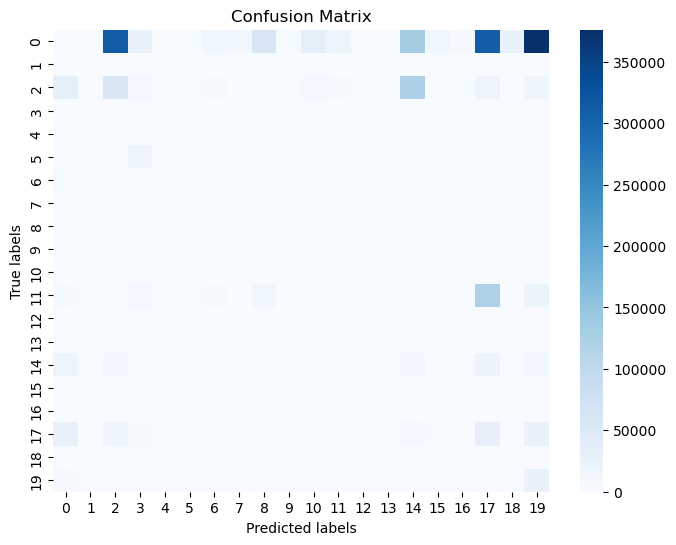

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(mask_arrays, preds_arrays)
cm[0][0] = 0 # ignore 0-class

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


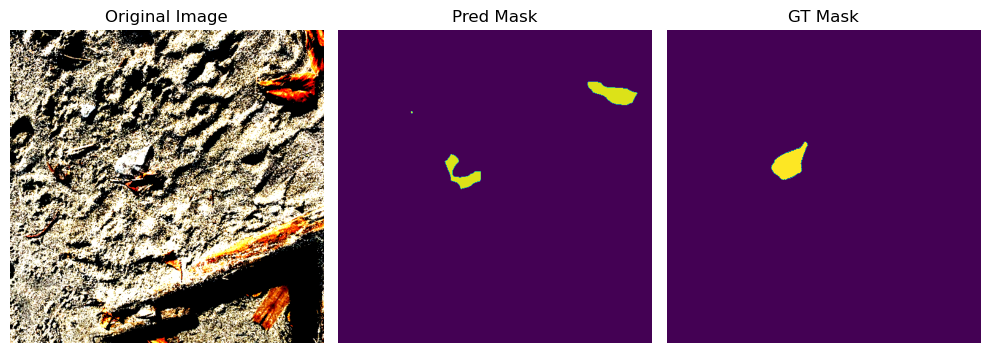

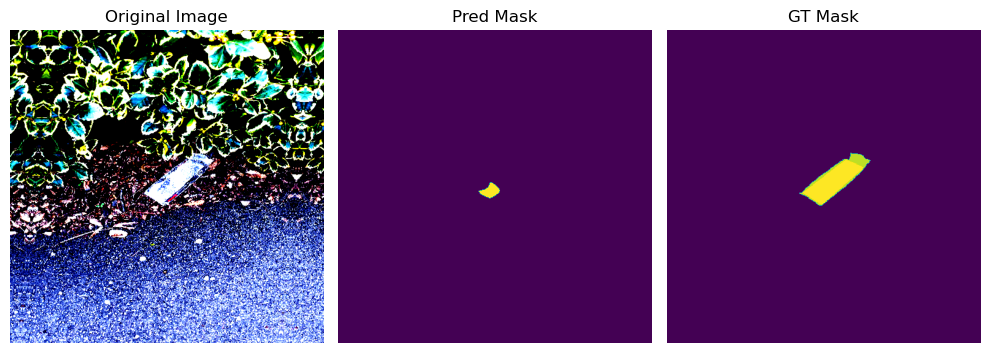

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


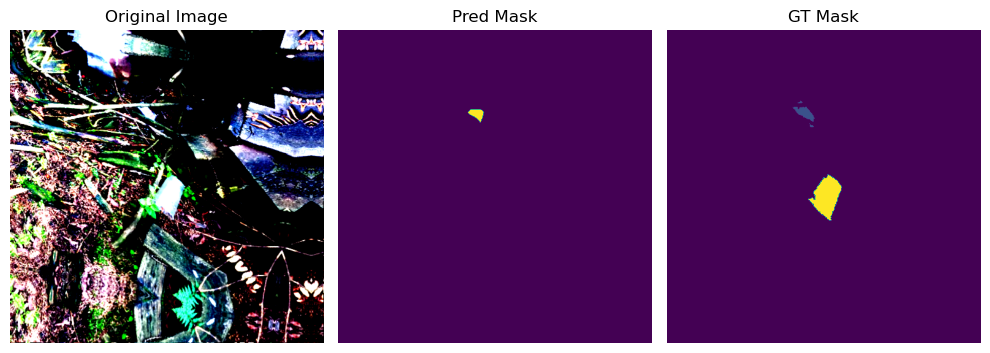

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


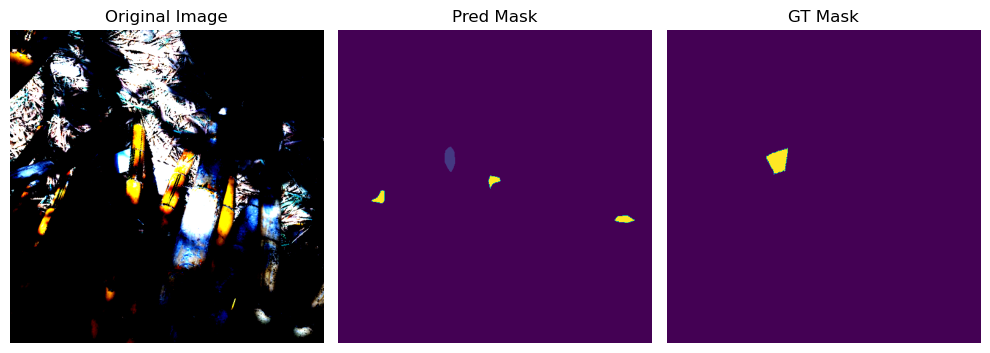

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


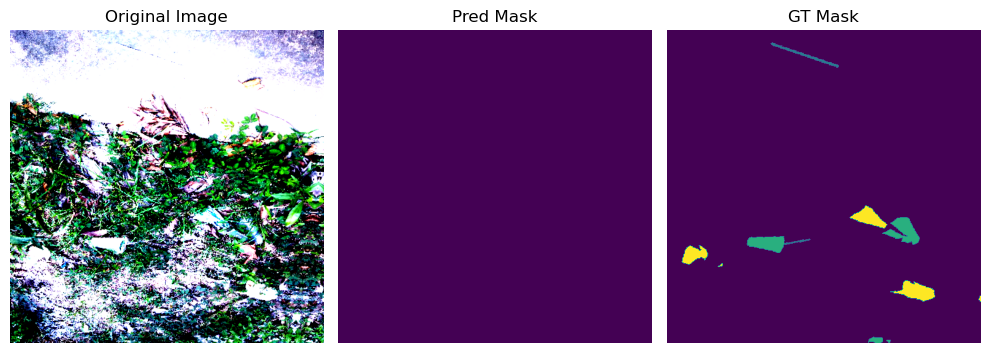

In [19]:
for images, preds_image, mask_image in example_of_preds:
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(images)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(preds_image)
    axes[1].set_title('Pred Mask')
    axes[1].axis('off')

    axes[2].imshow(mask_image)
    axes[2].set_title('GT Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()